# Train a CNN on gait cycles (TEMPLATE NOTEBOOK)

In [1]:
# Imports
import os
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
np.random.seed(42)

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Input, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard

from sklearn.utils import class_weight

Using TensorFlow backend.


In [2]:
# =============================================================================
# PARAMETERS
# =============================================================================

#File locations
output_dir = "/scratch/PI/euan/projects/mhc/code/daniel_code/results"
model_metrics = ['accuracy'] #,tpr,tnr,fpr,fnr,precision,f1]

#Training parameters
batch_size = 512

In [3]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
 
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0], batch_size = batch_size))).round()
        val_targ = self.validation_data[1]
        
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(f' — val_f1: {_val_f1} — val_precision: {_val_precision} — val_recall {_val_recall}')
        return
 
metrics = Metrics()

# Training

In [4]:
#Load 15 axis data
print('Beginning loading')
X_train = np.load('processed_datasets/gender_X_15.npy')
y_train = np.load('processed_datasets/gender_y_15.npy')
ids_train = np.load('processed_datasets/gender_ids_15.npy')

#X_train = np.load('processed_datasets/Sex_X_15_filtered.npy')
#y_train = np.load('processed_datasets/Sex_y_15_filtered.npy')
#ids_train = np.load('processed_datasets/Sex_ids_15_filtered.npy')

print('Finished loading, beginning X_train axis adjustment')

#Change X_train to weird format
X_train = np.expand_dims(X_train, 1)
X_train = np.swapaxes(X_train, -1, -2)

print('Beginning y_train encoding')

#Convert string to binary labels
y_train = y_train == 'Male'

#from sklearn.model_selection import train_test_split
#X_train, X_val, y_train, y_val, ids_train, ids_val = train_test_split(X_train, y_train, ids_train, train_size = 0.8)

#Randomize
if False:
    print('Data will be randomized.')
    idxs = np.arange(X_train.shape[0])
    np.random.shuffle(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]
    ids_train = ids_train[idxs]
else:
    print('Data is NOT randomized.')

print('Beginning data splitting')

split_num = int(0.8*X_train.shape[0])
X_val = X_train[split_num:]
y_val = y_train[split_num:]
ids_val = ids_train[split_num:]

X_train = X_train[:split_num]
y_train = y_train[:split_num]
ids_train = ids_train[:split_num]

X_train.shape, X_val.shape, y_train.shape, y_val.shape, ids_train.shape, ids_val.shape

Beginning loading
Finished loading, beginning X_train axis adjustment
Beginning y_train encoding
Data is NOT randomized.
Beginning data splitting


((2792549, 1, 15, 100),
 (698138, 1, 15, 100),
 (2792549,),
 (698138,),
 (2792549,),
 (698138,))

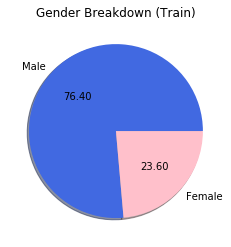

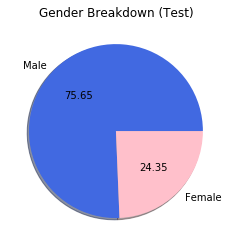

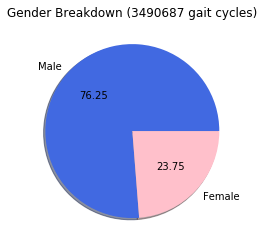

In [5]:
#Profile the dataset
num_male = np.sum(y_train == 1)
num_female = np.sum(y_train == 0)
plt.figure()
plt.pie([num_male, num_female], 
        labels = ['Male', 'Female'], 
        colors=['royalblue', 'pink'], 
        autopct = '%.2f', 
        shadow = True)
plt.title("Gender Breakdown (Train)")
plt.show()

#Profile the dataset
num_male = np.sum(y_val == 1)
num_female = np.sum(y_val == 0)
plt.figure()
plt.pie([num_male, num_female], 
        labels = ['Male', 'Female'], 
        colors=['royalblue', 'pink'], 
        autopct = '%.2f', 
        shadow = True)
plt.title("Gender Breakdown (Test)")
plt.show()

#Profile the dataset
num_male = np.sum(np.concatenate((y_train, y_val)) == 1)
num_female = np.sum(np.concatenate((y_train, y_val)) == 0)
plt.figure()
plt.pie([num_male, num_female], 
        labels = ['Male', 'Female'], 
        colors=['royalblue', 'pink'], 
        autopct = '%.2f', 
        shadow = True)
plt.title(f"Gender Breakdown ({num_male + num_female} gait cycles)")
plt.show()

In [ ]:
#Define a model
def get_model():
    from keras.layers import LSTM, Permute
    
    model = Sequential()
    # ENTRY LAYER
    model.add(Permute((2, 1), input_shape=(15, 100)))
    model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.0, return_sequences=True))
    model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.0, return_sequences=True))
    model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.0, return_sequences=False))

    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [6]:
import functools
import json

import keras.backend as K

from keras.layers import Permute, Dense, Input, Conv2D, concatenate, MaxPooling2D
from keras.layers import ELU, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.models import Model

# %load model_util
from keras.layers import Input
from keras.regularizers import l2


REG_P = dict(kernel_regularizer=l2(0.01))


def _create_input(input_shape, input_tensor=None, name='input'):
    """
    Select a correct input tensor based on shape and instance specification.

    # Arguments
        input_shape: Input shape tuple
        input_tensor: Existing tensor to wrap into the `Input` layer.
                      If set, the layer will not create a placeholder tensor.
        name: Name string for layer.

    # Returns
        Input Tensor
    """
    if input_tensor is None:
        return Input(shape=input_shape, name=name)

    if not K.is_keras_tensor(input_tensor):
        return Input(tensor=input_tensor, shape=input_shape, name=name)

    return input_tensor


def _conv_block(units, block=1, layer=1, sensor='acc'):
    """
    Create VGG style convolutional block.

    Deviations from original paper.
        - Remove `Dropout`
        - Added `BatchNormalization`
        - He-normal initialization
        - Uses `ELU` Activation
        
    # Arguments
        units: conv filters
        block: block number within network (used for naming)
        layer: layer number within block (used for naming)
        sensor: sensor name (used for naming)
        
    # Returns
        callable
    """
    def layer_wrapper(inp):
        x = Conv2D(units, (1, 3), padding='same', kernel_initializer='he_normal',
                   name=f'block{block}_conv{layer}_{sensor}', **REG_P)(inp)
        x = BatchNormalization(epsilon=0.23, name=f'block{block}_bn{layer}_{sensor}')(x)
        x = ELU(name=f'block{block}_act{layer}_{sensor}')(x)
        return x

    return layer_wrapper


def _dense_block(units, dropout=0.3, name='fc1'):
    """
    Create VGG fully connected block.

    # Deviations from original paper.
        - Added `BatchNormalization`
        - Uses `ELU` Activation
    
    # Arguments
        units: fc layer dimensionality
        dropout: dropout probability
        name: prefix for dense layers

    # Returns
        callable
    """

    def layer_wrapper(inp):
        x = Dense(units, name=f'{name}', **REG_P)(inp)
        x = BatchNormalization(epsilon=0.23, name=f'{name}_bn')(x)
        x = ELU(name=f'{name}_act')(x)
        x = Dropout(dropout, name=f'{name}_dropout')(x)
        return x

    return layer_wrapper


def _vgg_body(factor=2, sensor='acc'):
    """
    VGG Network Body containing convolutional blocks
    
    # Arguments
        factor: scaling factor to reduce network filter width
        sensor: sensor name
        
    # Return
        callable
    """

    _vgg_conv_block = functools.partial(_conv_block, sensor=sensor)

    def layer_wrapper(inp):
        x = Permute((1, 3, 2), name=f'swapaxes_{sensor}')(inp)

        # Block 1
        x = _vgg_conv_block(64 // factor, block=1, layer=1)(x)
        x = _vgg_conv_block(64 // factor, block=1, layer=2)(x)
        x = MaxPooling2D((1, 2), name=f'block1_pool_{sensor}')(x)

        # Block 2
        x = _vgg_conv_block(128 // factor, block=2, layer=1)(x)
        x = _vgg_conv_block(128 // factor, block=2, layer=2)(x)
        x = MaxPooling2D((1, 2), name=f'block2_pool_{sensor}')(x)

        # Block 3
        x = _vgg_conv_block(256 // factor, block=3, layer=1)(x)
        x = _vgg_conv_block(256 // factor, block=3, layer=2)(x)
        x = _vgg_conv_block(256 // factor, block=3, layer=3)(x)
        x = MaxPooling2D((1, 2), name=f'block3_pool_{sensor}')(x)

        # Block 4
        x = _vgg_conv_block(512 // factor, block=4, layer=1)(x)
        x = _vgg_conv_block(512 // factor, block=4, layer=2)(x)
        x = _vgg_conv_block(512 // factor, block=4, layer=3)(x)
        x = MaxPooling2D((1, 2), name=f'block4_pool_{sensor}')(x)

        # Block 5
        x = _vgg_conv_block(512 // factor, block=5, layer=1)(x)
        x = _vgg_conv_block(512 // factor, block=5, layer=2)(x)
        x = _vgg_conv_block(512 // factor, block=5, layer=3)(x)
        x = MaxPooling2D((1, 2), name=f'block5_pool_{sensor}')(x)

        return x

    return layer_wrapper

def VGG16Net(input_shape=None, input_tensor=(None, None),
             classes=1000, dropout=0.3, factor=2):
    """
    Modified VGG architecture
        https://arxiv.org/abs/1409.1556

    # Arguments
        input_shape: shape tuple
        input_tensor: Keras tensor (i.e. output of `layers.Input()`) to use as image input for the model.
        classes: optional number of classes to classify images
        dropout: dropout applied to fc layers
        factor: scaling factor to reduce network filter width

    # Returns
        A Keras model instance.
    """
    assert input_shape or all(input_tensor), f'Must provide at least one: input_shape, input_tensor'

    # Two Inputs
    img_input_acc = _create_input(input_shape, input_tensor=input_tensor[0], name='acc_input')

    # Accelerometer and Gyroscope Conv Blocks
    x = _vgg_body(factor=factor, sensor='acc')(img_input_acc)

    # Merge and Pool Channels
    x = GlobalAveragePooling2D(name='avgpool')(x)

    # FC Layers
    x = _dense_block(4098 // factor, dropout=dropout, name='fc1')(x)
    x = _dense_block(4098 // factor, dropout=dropout, name='fc2')(x)

    # Classification block
    if classes == 2:
        x = Dense(1, activation = 'sigmoid', name='predictions')(x)
    else:
        x = Dense(classes, activation='softmax', name='predictions')(x)

    return Model(img_input_acc, x, name='VGG16Net')

from keras.callbacks import ModelCheckpoint

class MultiGPUCheckpoint(ModelCheckpoint):
    """
    Drop in replacement for `ModelCheckpoint` callback which fixes a bug
    when saving models wrapped in `keras.utils.multi_gpu_model`.

    Please see:
        https://github.com/keras-team/keras/issues/8123#issuecomment-409395274

    Works with both single and multi-gpu configurations.
    """
    def set_model(self, model):
        layer = model.layers[-2]
        if isinstance(layer, Model) and layer.input_names == model.input_names:
            self.model = layer
        else:
            self.model = model
                

In [21]:
#Set the model up
#model = get_mod_model()
#model = get_model()
model = VGG16Net(input_shape=(1, 15, 100), classes=2)

print(model.summary())

#Define optimizer
adam = keras.optimizers.Adam() #Default lr is 0.001

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=model_metrics)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
acc_input (InputLayer)       (None, 1, 15, 100)        0         
_________________________________________________________________
swapaxes_acc (Permute)       (None, 1, 100, 15)        0         
_________________________________________________________________
block1_conv1_acc (Conv2D)    (None, 1, 100, 32)        1472      
_________________________________________________________________
block1_bn1_acc (BatchNormali (None, 1, 100, 32)        128       
_________________________________________________________________
block1_act1_acc (ELU)        (None, 1, 100, 32)        0         
_________________________________________________________________
block1_conv2_acc (Conv2D)    (None, 1, 100, 32)        3104      
_________________________________________________________________
block1_bn2_acc (BatchNormali (None, 1, 100, 32)        128       
__________

In [22]:
#Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=1e-7, verbose=1)

early_stop = EarlyStopping(patience=4, verbose=1, restore_best_weights=True)

#tb = TensorBoard(log_dir=os.path.join(output_dir, 'logs'), 
#                 write_graph=False,) 
                 #histogram_freq=5, 
                 #embeddings_freq=5, 
                 #embeddings_layer_names=['fc1'],
                 #mbeddings_data = X_val)

cb_list = [reduce_lr, early_stop, metrics]

In [ ]:
history = model.fit(x = X_train,#.squeeze().swapaxes(-1, -2),
                    y = y_train,
                    epochs=20,
                    validation_data = (X_val, y_val),#.squeeze().swapaxes(-1, -2), y_val),
                    callbacks = cb_list,
                    class_weight={0: 1.6218955904713634, 1: 0.7228371357578496}, #class_weights,
                    shuffle=True, 
                    batch_size = batch_size)

Train on 2792549 samples, validate on 698138 samples
Epoch 1/20
2792549/2792549 [==============================] - 197s 71us/step - loss: 1.5596 - acc: 0.7103 - val_loss: 0.6071 - val_acc: 0.7573
 — val_f1: 0.8615877268939828 — val_precision: 0.7577059850427811 — val_recall 0.9984796129923981
Epoch 2/20
2792549/2792549 [==============================] - 194s 69us/step - loss: 0.6739 - acc: 0.7132 - val_loss: 0.9134 - val_acc: 0.4603
 — val_f1: 0.4587624053216658 — val_precision: 0.9504279303407969 — val_recall 0.30235252908710514
Epoch 3/20
2792549/2792549 [==============================] - 194s 69us/step - loss: 0.5446 - acc: 0.7349 - val_loss: 1.1966 - val_acc: 0.4689

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
 — val_f1: 0.4763423470504735 — val_precision: 0.9376334519572954 — val_recall 0.31926991129497967
Epoch 4/20
2792549/2792549 [==============================] - 193s 69us/step - loss: 0.5087 - acc: 0.7534 - val_loss: 0.5917 - val_acc: 0.68

In [9]:
#Try a generator for fun
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, X, y, batch_size=512, shuffle=True):
        self.batch_size = batch_size
        self.y = y
        self.X = X
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.y) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        idxs = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Generate the batch
        X = self.X[idxs]
        y = self.y[idxs]
        
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
train_gen = DataGenerator(X_train, y_train)
val_gen = DataGenerator(X_val, y_val)

In [10]:
history = model.fit_generator(train_gen,
                    steps_per_epoch = 200,
                    epochs = 200,
                    validation_data = (X_val, y_val),#.squeeze().swapaxes(-1, -2), y_val),
                    callbacks = cb_list,
                    class_weight={0: 1.6218955904713634, 1: 0.7228371357578496}, #class_weights,
                    shuffle=True)

Epoch 1/200
200/200 [==============================] - 66s 331ms/step - loss: 23.1448 - acc: 0.7377 - val_loss: 4.9727 - val_acc: 0.7565
 — val_f1: 0.8613846772345598 — val_precision: 0.7565194846864087 — val_recall 1.0
Epoch 2/200
200/200 [==============================] - 24s 121ms/step - loss: 2.2930 - acc: 0.7684 - val_loss: 1.1662 - val_acc: 0.7565
 — val_f1: 0.8613846772345598 — val_precision: 0.7565194846864087 — val_recall 1.0
Epoch 3/200
200/200 [==============================] - 21s 103ms/step - loss: 0.8291 - acc: 0.7656 - val_loss: 0.7476 - val_acc: 0.7642
 — val_f1: 0.860622029703599 — val_precision: 0.7783980738657771 — val_recall 0.9622686521949049
Epoch 4/200
200/200 [==============================] - 21s 103ms/step - loss: 0.6124 - acc: 0.7613 - val_loss: 0.5848 - val_acc: 0.7562
 — val_f1: 0.86120637696242 — val_precision: 0.7564525049215842 — val_recall 0.9996364703543468
Epoch 5/200
200/200 [==============================] - 21s 103ms/step - loss: 0.5560 - acc: 0.76

In [11]:
model.save('models/gender_model_15.h5')

# Visualize Results

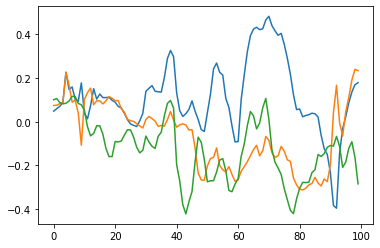

In [12]:
plt.plot(X_train.squeeze()[0, 0:3].T)

In [13]:
#Example predictions
pred = np.round(model.predict(X_val, batch_size = batch_size)).squeeze()#.squeeze().swapaxes(-1, -2))).squeeze()
print(f"{pred.sum()/len(pred)} of the predictions were 1 (Male)")

0.9883561702700612 of the predictions were 1 (Male)


In [14]:
np.sum(pred == y_val), pred.shape

(531348, (698138,))

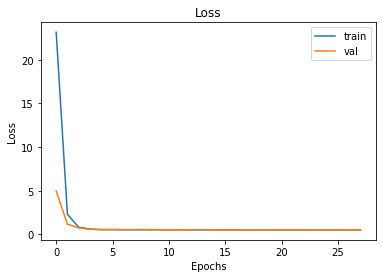

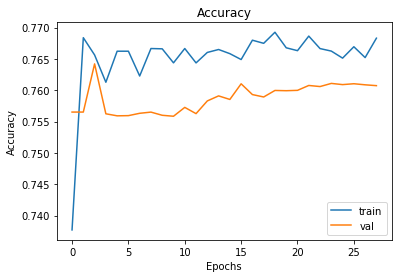

In [15]:
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

plt.figure()
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()

In [16]:
y_pred = model.predict(X_val, batch_size = batch_size)

Text(0.5, 1, 'Gender Prediction Confusion Matrix')

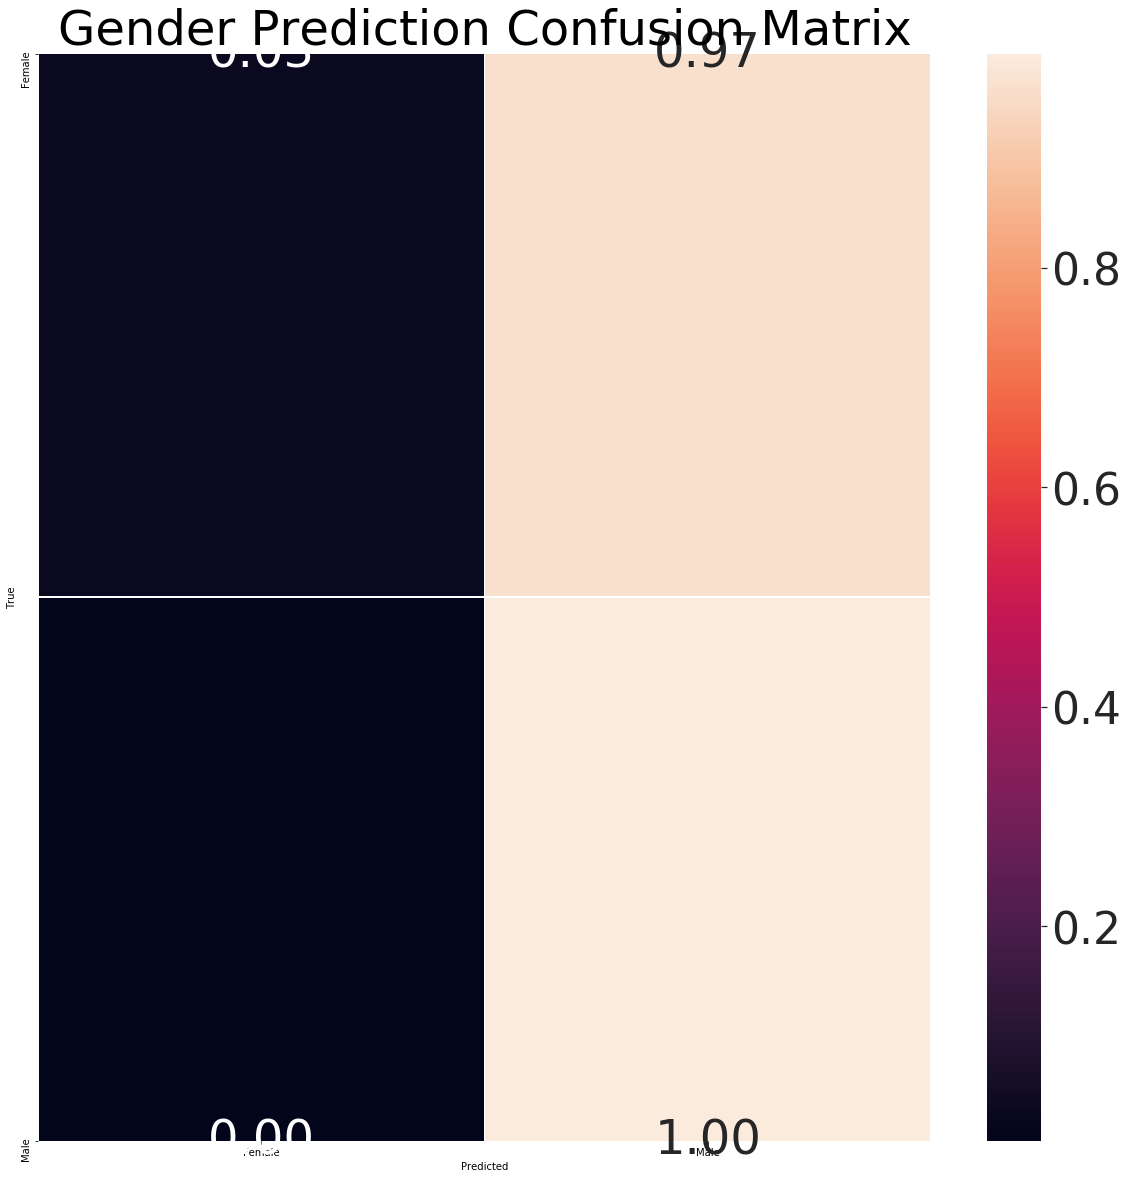

In [18]:
#Print confusion matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,20)) 
df_results=pd.DataFrame(data=np.column_stack((y_val,y_pred.round())),columns=['True','Predicted'])
CT_results=pd.crosstab(df_results["True"], df_results["Predicted"]).apply(lambda r: r/r.sum(), axis=1)

#Make a heatmap
sns.set(font_scale = 4)
sns.heatmap(CT_results, 
            annot=True,
            xticklabels = ['Female', 'Male'],
            yticklabels = ['Female', 'Male'],
            fmt=".2f", 
            linewidths=.5,
            ax=ax)
plt.title('Gender Prediction Confusion Matrix')

In [ ]:
#ROC curve
from sklearn import metrics
y_score = model.predict(X_val, batch_size = batch_size)
fpr, tpr, threshs = metrics.roc_curve(y_val, y_score)

print("AUROC: {}".format(metrics.roc_auc_score(y_val, y_score)))

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [ ]:
#PRC
p, r, threshs = metrics.precision_recall_curve(y_val, y_score)

print("AUROC: {}".format(metrics.average_precision_score(y_val, y_score)))

plt.figure()
plt.plot(p, r)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()

# Get user-level predictions

In [ ]:
y_round = y_pred.round()

unique_ids = np.unique(ids_val)
print(f'There are {len(unique_ids)} unique ids in our val set.')

user_preds = []
user_trues = []

overall_acc = []
male_acc = []
female_acc = []
for usr_id in unique_ids:
    
    usr_idxs = np.nonzero(ids_val == usr_id)[0]
    
    #print(f'User {usr_id} has {len(usr_idxs)} in the val set.')

    temp = np.sum(y_round[usr_idxs])/len(usr_idxs)
    pred = temp > 0.5
    true = y_val[usr_idxs[0]]
    #print(f'This user has label {true} with vote {temp} leading to a aggregate prediction of {pred}.')

    user_preds.append(pred)
    user_trues.append(true)
    
    overall_acc.append(true == pred)
    if true == 1:
        male_acc.append(true == pred)
    else:
        female_acc.append(true == pred)

In [ ]:
np.sum(overall_acc)/len(overall_acc)

In [ ]:
np.sum(female_acc)/len(female_acc)

In [ ]:
np.sum(male_acc)/len(male_acc)

In [ ]:
#Print confusion matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,20)) 
df_results=pd.DataFrame(data=np.column_stack((user_trues, user_preds)),columns=['True','Predicted'])
CT_results=pd.crosstab(df_results["True"], df_results["Predicted"]).apply(lambda r: r/r.sum(), axis=1)

#Make a heatmap
sns.set(font_scale = 4)
sns.heatmap(CT_results, 
            annot=True,
            xticklabels = ['Female', 'Male'],
            yticklabels = ['Female', 'Male'],
            fmt=".2f", 
            linewidths=.5,
            ax=ax)
plt.title('Gender Prediction Confusion Matrix')

# SHAP it

In [ ]:
import shap
shap.initjs()

In [ ]:
# select a set of background examples to take an expectation over
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)

In [ ]:
random_idxs = np.random.choice(np.arange(X_val.shape[0]), 5)
print(random_idxs)

shap_values = e.shap_values(X_val[random_idxs])

#Hack the dims a little
shap_values = [np.transpose(value, (0, 2, 3, 1)) for value in shap_values]
im_val = np.transpose(X_val, (0, 2, 3, 1))

# plot the feature attributions
plt.figure(figsize=(25, 10))
shap.image_plot(shap_values, -im_val[random_idxs], width = 100, aspect = 1)

In [ ]:
# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)

sns.set(font_scale = 1)

def plot_colored_data(data, color, shap_color_scale = None, fignum = 0, colorbar = False):
    from matplotlib.collections import LineCollection

    x = np.arange(0, len(data)) / 100
    points = np.array([x, data]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    fig = plt.figure(fignum)
    ax = plt.gca()

    # Create a continuous norm to map from data points to colors
    if shap_color_scale == None:
        norm = plt.Normalize(min(color), max(color))
    else:
        norm = plt.Normalize(-shap_color_scale, shap_color_scale)
    lc = LineCollection(segments, cmap='RdBu', norm=norm)

    # Set the values used for colormapping
    lc.set_array(color)
    lc.set_linewidth(2)
    line = ax.add_collection(lc)
    if colorbar:
        fig.colorbar(line, ax = ax)

    
def plot_window_saliency(image, shap, base_fignum = 0):
    wc_data = image.squeeze()
    wc_saliency = shap.squeeze()
    largest_shap = np.max(np.abs(wc_saliency))

    #Plotting Accel
    plt.figure(base_fignum)
    for i in range(4):
    
        plot_colored_data(wc_data[i], wc_saliency[i], largest_shap, fignum = base_fignum, colorbar = i == 3)
    
    plt.title('Saliency of acceleration')
    plt.ylabel('Acceleration (g)')
    plt.xlabel('Shap values')
    plt.xlim([0, 1])
    plt.ylim([np.min(wc_data[0:4]) - 0.5, np.max(wc_data[0:4]) + 0.5])
    
    #Plotting gyro
    plt.figure(base_fignum + 1)
    for i in range(4, 8):
    
        plot_colored_data(wc_data[i], wc_saliency[i], largest_shap, fignum =base_fignum +  1, colorbar = i == 7)
    
    plt.title('Saliency of gyroscope')
    plt.ylabel('Angular Acceleration (rad/s)')
    plt.xlabel('Shap values')
    plt.xlim([0, 1])
    plt.ylim([np.min(wc_data[4:8]) - 0.5, np.max(wc_data[4:8]) + 0.5])
    
    plt.figure(base_fignum + 2)
    for i in range(8,12):
    
        plot_colored_data(wc_data[i], wc_saliency[i], largest_shap, fignum =base_fignum +  2, colorbar = i == 11)
    
    plt.title('Saliency of attitude')
    plt.ylabel('Attitude')
    plt.xlabel('Shap values')
    plt.xlim([0, 1])
    plt.ylim([np.min(wc_data[8:12]) - 0.5, np.max(wc_data[8:12]) + 0.5])
    
    plt.figure(base_fignum + 3)
    for i in range(12, 15):
    
        plot_colored_data(wc_data[i], wc_saliency[i], largest_shap, fignum =base_fignum +  3, colorbar = i == 14)
    
    plt.title('Saliency of gravity')
    plt.ylabel('Gravity (g)')
    plt.xlabel('Shap values')
    plt.xlim([0, 1])
    plt.ylim([np.min(wc_data[12:15]) - 0.5, np.max(wc_data[12:15]) + 0.5])
    
def plot_cycle_saliency(model, X_train, X_val):
    import shap
    shap.initjs()
    
    # select a set of background examples to take an expectation over
    background = X_train[np.random.choice(X_train.shape[0], 200, replace=False)]

    # explain predictions of the model on four images
    e = shap.DeepExplainer(model, background)
    
    #Choose some random cycles to plot
    random_idxs = np.random.choice(np.arange(X_val.shape[0]), 5)
    val_cycles = X_val[random_idxs]

    shap_values = e.shap_values(val_cycles)[0]
    
    for idx in range(len(random_idxs)):
        print(f"Walk Cycle {idx}")
        plot_window_saliency(val_cycles[idx], shap_values[idx], 4*idx)
        plt.show()
        
plot_cycle_saliency(model, X_train, X_val)

# That's it folks!

Text(0.5, 1, 'Gender Prediction Confusion Matrix')

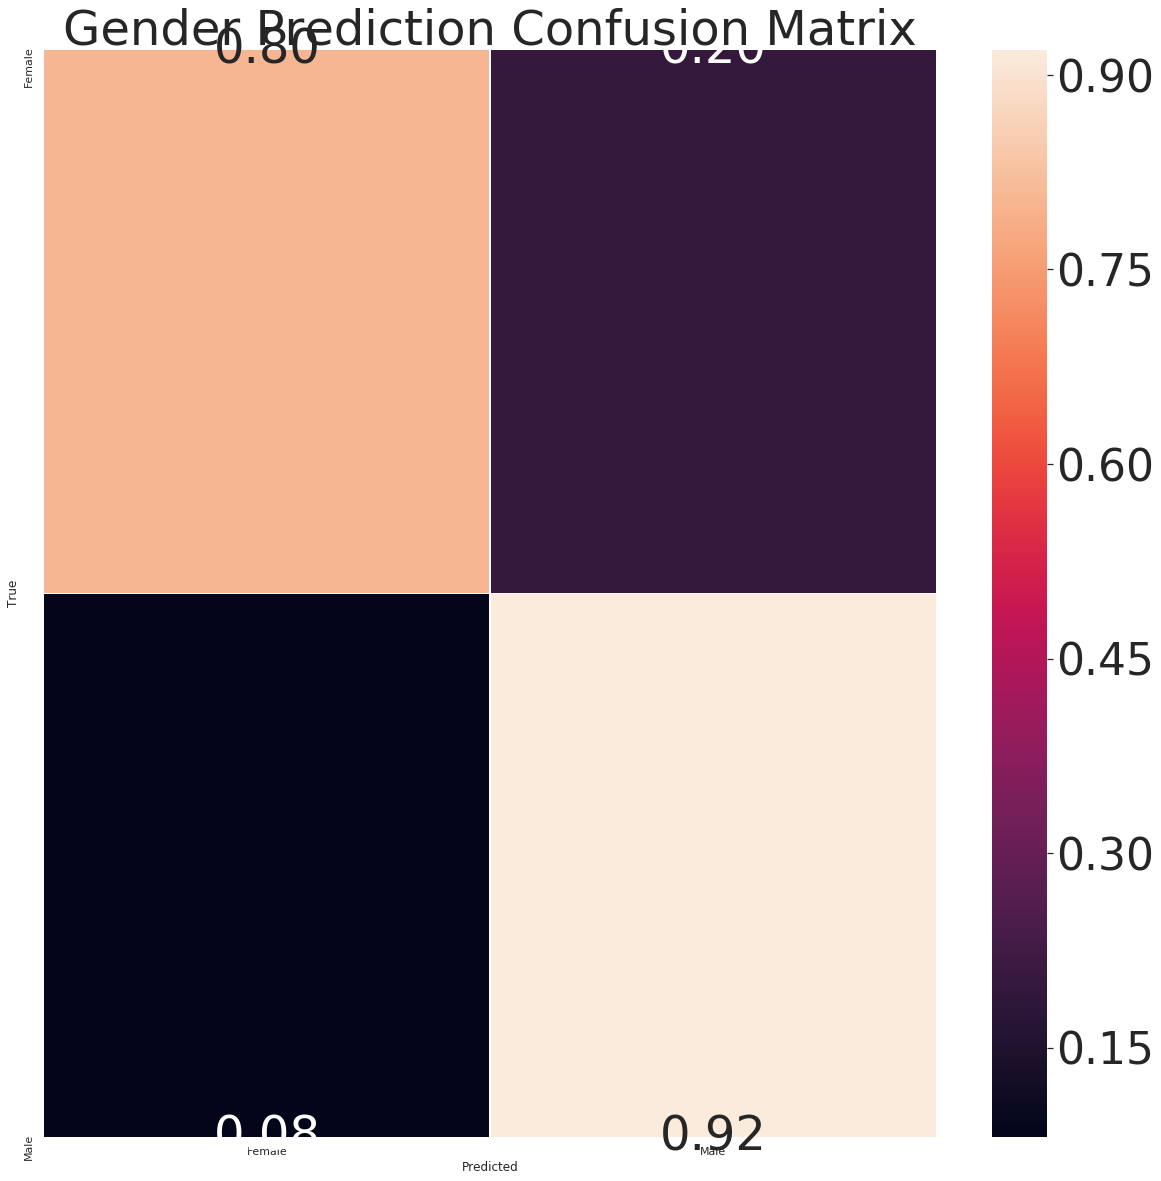

In [85]:
#Print confusion matrix
import seaborn as sns
y_pred = model.predict(X_val, batch_size = batch_size)
fig, ax = plt.subplots(figsize=(20,20)) 
df_results=pd.DataFrame(data=np.column_stack((y_val,y_pred.round())),columns=['True','Predicted'])
CT_results=pd.crosstab(df_results["True"], df_results["Predicted"]).apply(lambda r: r/r.sum(), axis=1)

#Make a heatmap
sns.set(font_scale = 4)
sns.heatmap(CT_results, 
            annot=True,
            xticklabels = ['Female', 'Male'],
            yticklabels = ['Female', 'Male'],
            fmt=".2f", 
            linewidths=.5,
            ax=ax)
plt.title('Gender Prediction Confusion Matrix')